# Evaluation of CT usign OpenAI as an annotator to replace the expert annotators

Art or Artifice? Large Language Models and the False Promise of Creativity

The Creativity_eval (Also available in https://huggingface.co/datasets/Salesforce/ttcw_creativity_eval) is a LLM Creativity Benchmark released the March 2024 and the basic idea for this benchmark is basically using TTCT human Creativity evaluations protocols to do Evaluation of LLM generated responses.


In this study, this CT tasks are implemented by the following steps:

1. Generate responses iteratally based on the plot provided in the dataset.

| Plot                                                                                                                          | Answer | Evaluation_prompt | Evaluation_results |
|--------------------------------------------------------------------------------------------------------------------------------------------|--------|------------------|--------------------|
|A woman experiences a disorienting night in a maternity ward where she encounters other similarly disoriented new mothers, leading to an uncanny mix-up where she leaves the hospital with a baby that she realizes is not her own, yet accepts the situation with an inexplicable sense of happiness. | It was a night like any other in the maternity ward of the hospital. The beeping of monitors, the cooing of newborns, the weary sighs of new mothers. But for one young woman, this night would be different. As she lay in her hospital bed, staring at the ceiling with a mix of exhaustion and disorientation, she couldn't shake the feeling that something was off. The beeping of the monitors seemed too loud, the cooing of the newborns seemed too shrill, and the weary sighs of the other mothers seemed too... relieved. She tried to shake off the feeling, telling herself it was just the aftermath of a long and difficult labor. But as the night wore on, the disorientation only grew stronger. She couldn't remember the last time she had eaten, or how she had gotten to the hospital. She couldn't even remember the face of her husband, or the sound of her own voice. It was then that she noticed the baby in her arms. She had no idea how it got there, or why she was holding it. She looked around the room, but everyone else seemed to be in the same state of confusion. The nurses and doctors were bustling around, but they too seemed to be in a daze. As the night wore on, the young woman tried to make sense of the situation. She couldn't shake the feeling that something was very wrong, but at the same time, she couldn't help but feel a strange sense of happiness. It was as if she had been given a precious gift, one that she couldn't quite explain or understand. She looked down at the baby in her arms, and saw that it was a little boy with bright blue eyes and a mop of curly hair. He looked up at her with a smile, and she felt her heart swell with love. She didn't know this baby, but she knew that she was meant to be its mother. As the night wore on, the young woman tried to make sense of the situation. She couldn't shake the feeling that something was very wrong, but at the same time, she couldn't help but feel a strange sense of happiness. She knew that she had been given a great gift, one that she would cherish and protect with all her might. And so, she left the hospital with the baby in her arms, knowing that she would never be able to explain or understand the strange events of that night. But she also knew that she would never let go of the baby, or the happiness that it had brought her. It was a mystery that would stay with her forever, a reminder of the unpredictable and unexplainable nature of life. |You are given a creative short-story. Read it carefully. You are then given some background about specific aspects of creative writing, as well as a binary (Yes/No) question. Your objective is to use the background information to answer the question about the story. Start your answer with Yes or No. You can optionally then provide a short explanation for your answer.  **Story:** It was a night like any other in the maternity ward of the hospital. The beeping of monitors, the cooing of newborns, the weary sighs of new mothers. But for one young woman, this night would be different. **Background:** If the writer ends the piece simply because they are 'tired of writing', the conclusion might feel abrupt, disjointed, or unfulfilling to the reader. It suggests a rushed ending, where plot threads might be left unresolved and character arcs incomplete. Conversely, if the writer concludes because they've reached 'the moment the entire piece has been leading readers towards', it implies a well-considered and purposeful ending. The events, character development, and themes throughout the story have built towards this climactic moment, providing a satisfying resolution to the reader. A strong ending offers a sense of closure, ties up the central conflicts or questions of the story, and generally leaves the reader feeling that the narrative journey was worthwhile and complete. **Question:** Does the end of the story feel natural and earned, as opposed to arbitrary or abrupt? Remember to start your answer with Yes or No. You can optionally then provide a short explanation for your answer.| Yes, the end of the story feels natural and earned, as opposed to arbitrary or abrupt. The narrative builds a sense of mystery and disorientation that mirrors the protagonist's own feelings throughout the storyline. The element of confusion—her inability to remember significant details of her life and how she arrived at the hospital—is steadily maintained, making her final acceptance and love toward the baby a moment that the story logically builds towards. Despite the unresolved mystery, which adds intrigue, her decision to cherish and protect the baby provides a thematic resolution, emphasizing themes like the unexplainable nature of life and the instantaneous bond of maternal love. This resolution aligns with the story's buildup and character development, providing a thematically satisfying conclusion.


2. Then get the response from models and calculate the accuracy score evaluated by ChatGPT models.
3. Finally, do the statistical analysis and causal modeling for future usage.


In [1]:
import pandas as pd
import time
from tqdm import tqdm
import os
import re
import string
from collections import Counter
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from rouge_score import rouge_scorer
from bert_score import score
from nltk.translate import meteor_score
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import matplotlib.pyplot as plt
from openai import OpenAI
from bert_score import BERTScorer

from llama_index.llms import OpenAI
from openai import OpenAI
import json
import pandas as pd
from langchain import PromptTemplate
from tqdm import tqdm


file_name = "exp_result_Meta-Llama-3-70B-Instruct_20240531194751_952843.csv"
foler_path = "data/CT"

output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.
2024-06-07 21:13:30.088981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


CT design for evaluation

In [2]:
# Need to be downloaded from the creativity_eval github
with open(
    "Paper Experiment Results/New_filtered/creativity/creativity_eval-main/creativity_eval-main/tests/ttcw_all_tests.json",
    "r",
) as f:
    tests = json.load(f)


# Based on the create_eval code
def full_prompt2context(full_prompt):
    lines = full_prompt.strip().split("\n")
    kept1 = "\n".join(lines[:-1]).strip().split("\n")
    kept2 = kept1[:-1]
    return "\n".join(kept2).strip()


for test in tests:
    test["expanded_context"] = full_prompt2context(test["full_prompt"])


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def extract_final_response(response, prompt):
    return response[len(prompt) :]


evaluation_df = pd.DataFrame(tests)

In [3]:
evaluate_prompt = """You are given a creative short-story. Read it carefully. You are then given some background about specific aspects of creative writing, as well as a binary (Yes/No) question. Your objective is to use the background information to answer the question about the story. Start your answer with Yes or No. You can optionally then provide a short explanation for your answer.

==========
Story:
{story}
==========
Background:
{background}

==========
Question: {question}

Remember to start your answer with Yes or No. You can optionally then provide a short explanation for your answer.
"""

evaluate_prompt_template = PromptTemplate.from_template(evaluate_prompt)

In [4]:
import pandas as pd

stories_generated_df = pd.read_csv(input_path)

if "story_generated" in stories_generated_df.columns:
    print("Detected new version results")
    stories_generated_df["pure_response"] = stories_generated_df["story_generated"]
else:
    print("Detected old version results")
    stories_generated_df["pure_response"] = stories_generated_df["generated_response"]

cartesian_product_df = pd.merge(
    evaluation_df.assign(key=0),
    stories_generated_df.assign(key=0),
    how="outer",
    on="key",
).drop("key", axis=1)

print("cartesian_product rows:", cartesian_product_df.shape[0])
print("cartesian_product columns:", cartesian_product_df.columns)

cartesian_product_df["formatted_prompt"] = cartesian_product_df.apply(
    lambda row: evaluate_prompt_template.format(
        story=row["pure_response"],
        background=row["expanded_context"],
        question=row["question"],
    ),
    axis=1,
)

Detected new version results
cartesian_product rows: 1176
cartesian_product columns: Index(['ttcw_idx', 'torrance_dimension', 'category', 'question', 'full_prompt',
       'expanded_context', 'Unnamed: 0', 'Temperature', 'story_idx',
       'story_name', 'plot', 'content', 'word_count', 'initial_prompt',
       'llama2_chat_initial_prompt', 'mixtral_instruct_initial_prompt',
       'llama3_chat_initial_prompt', 'llama2_chat_initial_prompt_recurrent',
       'mixtral_instruct_initial_prompt_recurrent',
       'llama3_chat_initial_prompt_recurrent', 'generated_response',
       'story_generated', 'timestamp', 'elapsed_time', 'temperature', 'model',
       'repetition_times', 'pure_response'],
      dtype='object')


In [5]:
import os

if os.path.exists(output_path):
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    last_idx = 0

generated_responses = []
client = OpenAI(api_key=api_key)
with tqdm(total=len(cartesian_product_df)) as pbar:
    for index, row in cartesian_product_df.iterrows():
        if index < last_idx:
            pbar.update(1)
            continue
        response = (
            client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[
                    {"role": "user", "content": row["formatted_prompt"]},
                ],
            )
            .choices[0]
            .message
        ).content
        generated_responses.append(response)
        updated_row = row.copy()
        updated_row["OpenAI_response"] = response
        updated_dataframe = pd.DataFrame([updated_row])
        pbar.update(1)
        if not os.path.exists(output_path):
            updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
        else:
            updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)

100%|██████████| 1176/1176 [00:00<00:00, 60609.99it/s]


In [ ]:
def label_function(x):
    if str(x).startswith("Yes"):
        return "yes"
    elif str(x).startswith("No"):
        return "no"
    else:
        return "Error"


data_evaluated["label"] = data_evaluated["OpenAI_response"].apply(label_function)

# Analysis Integrated

In [6]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "data/CT"
output_photo_name = f"CT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        print(file_path)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

data/CT/exp_result_Mistral-7B-Instruct-v0.2_20240531193523_952844_evaluated.csv
data/CT/exp_result_Meta-Llama-3-8B-Instruct_20240531193412_952839_evaluated.csv
data/CT/exp_result_Meta-Llama-3-70B-Instruct_20240531194751_952843_evaluated.csv
data/CT/exp_result_Mixtral-8x7B-Instruct-v0.1_20240531194727_952845_evaluated.csv
data/CT/exp_result_Llama-2-13b-chat-hf_evaluated.csv
data/CT/exp_result_Llama-2-70b-chat-hf_evaluated.csv
data/CT/exp_result_Llama-2-7b-chat-hf_evaluated.csv


In [7]:
def label_function(x):
    if str(x).startswith("Yes"):
        return True
    elif str(x).startswith("No"):
        return False
    else:
        return None


df["label"] = df["OpenAI_response"].apply(label_function)
df = df[~df["label"].isna()]
df = df[df["Temperature"] != "temperature"]
df["Temperature"] = df["Temperature"].astype(float).round(1)

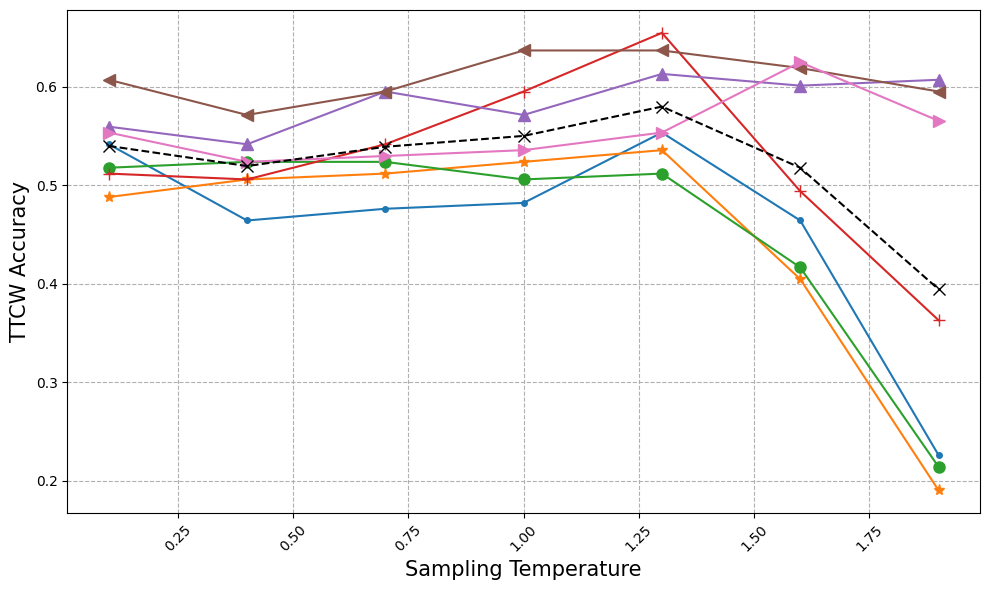

In [10]:
grouped_data = df.groupby(["model", "Temperature"])["label"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["label"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Sampling Temperature", fontsize=15)
plt.ylabel("TTCW Accuracy", fontsize=15)
# plt.title(
#     "Creativity\n Mean TTCW Accuracy with Temperature Across Models - Creativity Eval"
# )
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [4]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "label"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
corr_pearson, p_value_pearson = pearsonr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
print(f"Pearson correlation Coefficient: {corr_pearson:.3f}")
print(f"Pearson_p_value: {p_value_pearson:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

Average Performance: 0.520
Spearman correlation Coefficient: -0.057
p_value: 0.000
Pearson correlation Coefficient: -0.057
Pearson_p_value: 0.000
Range Percentage: 35.638%
Coefficient of Variation: 11.375


In [5]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["label"].values
    corr, p_value = spearmanr(temperatures, accuracy)

    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params

    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)


# for model in models:
#     # print(f"Model: {model}")
#     print(f"{correlations[model]}")
# print()
# for model in models:
#     print(f"{p_values[model]}")

# for model in models:
#     print(f"Model: {model}")
#     print(f"Kendall correlation: {correlations[model]}")
#     print(f"p-value: {p_values[model]}")
#     print(f"OLS summary:")
#     print(ols_results[model].summary())
#     print()

results_df.to_csv("output.csv")